## Stream video data to the NN

In [19]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import rospy
import time
import os
import PIL
import matplotlib.pyplot as plt
from scipy import misc
import tensorflow as tf
import numpy as np
from deep_car.model import get_model
from deep_car.data import get_steering_delta, get_steering_hist, continuous
from PIL import ImageDraw, ImageFont, ImageFilter
#from sensor_msgs.msg import CompressedImage
#from std_msgs.msg import String,Int16


check = 1
s_hist = [0]* 8

delta_discretize_min = -36 - 4.5
delta_discretize_max = 36 + 4.5
delta_discretize_buckets = 9

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Init NN

In [3]:
gpu_options = tf.GPUOptions(allow_growth=True) 
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

saver = tf.train.import_meta_graph('../data/model/steering_mixture_prob_exp.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint('../data/model/'))

graph = tf.get_default_graph()

x_img = graph.get_tensor_by_name("image:0")
steering_hist = graph.get_tensor_by_name("steering_hist:0")
y_delta_prob = graph.get_tensor_by_name("deep_car/y_delta_prob:0")
y_abs_discr_prob = graph.get_tensor_by_name("deep_car/y_abs_discr_prob:0") 


len_steering_hist = 4 #get_steering_hist(batch).shape[-1]
len_steering_delta = 6 #get_steering_delta(batch).shape[-1]
y_delta_buckets = 9
input_size = (64,48)
crop_size = input_size

INFO:tensorflow:Restoring parameters from ../data/model/steering_mixture_prob_exp.ckpt


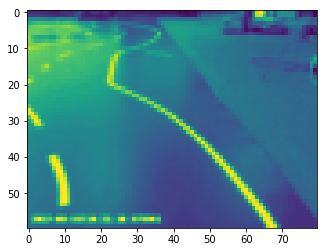

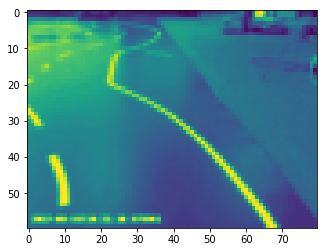

0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0]


TypeError: 'float' object is not iterable

In [22]:
def callbackNN(img):
    X = crop(img)
    hist_special = [[s_hist[-8], s_hist[-4], s_hist[-2], s_hist[-1]]]
    y_abs, y_delt = sess.run(
        [ y_abs_discr_prob, y_delta_prob], 
        feed_dict={
            x_img:X, 
            steering_hist: np.array(hist_special)
        }
    )
    
    index_delta = np.random.choice(len(y_delt[0]), p=y_delt[0])
    cont_delta = continuous(
        index_delta, 
        delta_discretize_buckets, 
        min=delta_discretize_min, 
        max=delta_discretize_max
    )
    
    abs_value = s_hist[-1] + cont_delta
    s_hist.append(abs_value)
    pub_steering.publish(abs_value)
    return abs_value
       
#rospy.init_node('PixelDriveNN')

#Crop the middle
def crop(img):
    crop_size = (64, 48)
    resize = (80, 60)
    img = img.convert('L').resize(resize, resample=PIL.Image.BILINEAR)
    plt.imshow(img)
    plt.show()
    img = img.crop(
        map(
            int,
            [ 0.5 * (resize[0] - crop_size[0]), 
              0.5 * (resize[1] - crop_size[1]),
              0.5 * (resize[0] + crop_size[0]),
              0.5 * (resize[1] + crop_size[1])])
    )
    np_img = np.asarray(img)
    return np_img[np.newaxis,:,:,np.newaxis]

f = PIL.Image.open("../tmp/tmpyDPJt4/000451.png")
img = np.array(f)
image = crop(f)
abs_prob, delta_prob = callbackNN(f)

fig, ax = plt.subplots(figsize=(10, 5))
print delta_prob.shape
ax.bar(np.arange(180) - 90, np.exp(abs_prob.flatten()))

In [ ]:
sub = rospy.topics.Subscriber("/app/camera/rgb/image_raw/compressed", CompressedImage, callbackNN)

In [ ]:
pub_steering = rospy.Publisher("/manual_control/steering", Int16, queue_size=10)
pub_speed = rospy.Publisher("/manual_control/speed", Int16, queue_size=10)

In [ ]:
pub_steering.publish(0)
time.sleep(0.5)
for i in range(90):
    time.sleep(0.1)
    pub_steering.publish(i)

In [ ]:
pub_speed.publish(0)